# Python: Difference-in-Differences Pre-Testing

This example illustrates how to use the Difference-in-Differences implmentation `DoubleMLDID` of the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to pre-test the parallel trends assumptions.
The example is based on the great implmentation of the [did-package](https://cran.r-project.org/web/packages/did/vignettes/did-basics.html) in `R`. 
You can find further references and a detailed guide on pre-testing with the `did`-package at the [did-package pre-testing documentation](https://cran.r-project.org/web/packages/did/vignettes/pre-testing.html).

At first, we will generate some data to evaluate the corresponding effect estimates. The DGP is slightly adjusted from [did-package pre-testing documentation](https://cran.r-project.org/web/packages/did/vignettes/pre-testing.html) to consider conditional non-linear parallel trends.

In [2]:
import numpy as np
import pandas as pd
from doubleml import DoubleMLData, DoubleMLDID
from lightgbm import LGBMClassifier, LGBMRegressor

In [88]:
n_obs = 1000
n_time_periods = 3

time_periods = (np.arange(2*n_time_periods) - n_time_periods)

theta = np.ones(shape=(n_obs, 2*n_time_periods)) + time_periods 
eta = np.random.normal(loc=0, scale=1, size=(n_obs,1))

mu_means = np.concatenate((np.zeros(n_time_periods) , np.arange(n_time_periods, 0, -1)))
mu = np.random.normal(loc=0, scale=1, size=(n_obs, 2*n_time_periods)) + mu_means

X = np.random.normal(loc=0, scale=1, size=(n_obs, 4))
g_X = (np.exp(X[:, 1]) - np.sin(5*X[:, 2])).reshape(-1,1)


#treatment = np.random.choice([0,1], size=(n_obs,1))
# not experimental
f_ps = 0.75*(-X[:, 0] + 0.5*X[:, 1] - 0.25*X[:, 2] - 0.1*X[:, 3])
ps = (np.exp(f_ps) / (1 + np.exp(f_ps))).reshape(-1,1)
u = np.random.uniform(low=0, high=1, size=(n_obs,1))
treatment = 1.0 * (ps >= u)

u = np.random.uniform(0,1, size=(n_obs,1))
epsilon = np.random.normal(loc=0, scale=1, size=(n_obs, 2*n_time_periods))
Y = theta + eta + treatment*mu + g_X + epsilon

data = pd.DataFrame(np.column_stack((Y, treatment, X)),
                    columns = [f'Y_{t}' for t in time_periods] + ['d'] + [f'X_{i}' for i in range(4)])
data

,Y_-3,Y_-2,Y_-1,Y_0,Y_1,Y_2,d,X_0,X_1,X_2,X_3
0,-1.012014,2.437158,3.967563,6.002664,4.966079,5.084814,1.0,-0.218110,0.652838,-0.932818,1.433802
1,-0.927981,2.250957,1.998130,2.430533,4.678416,5.005846,0.0,-0.588116,0.872303,2.332810,-0.998610
2,-0.377386,-0.579118,3.519204,7.276683,6.842503,6.788165,1.0,0.431767,0.539375,1.120662,0.233400
3,0.421923,1.283519,3.215601,3.283251,5.257422,5.493480,0.0,0.273865,0.996770,-0.895981,0.161275
4,2.685359,-0.607918,0.879666,5.476656,3.623315,5.346530,1.0,0.013892,-1.684919,-0.061408,-1.417434
...,...,...,...,...,...,...,...,...,...,...,...
995,-2.732499,-1.931303,2.486154,4.593752,1.997740,6.613737,1.0,-0.043201,0.303929,0.085561,0.018854
996,-0.609212,-0.211967,0.839439,2.153597,2.849267,4.910150,0.0,-0.387348,0.737522,0.725730,-0.937201
997,-3.309165,-2.135690,-2.237464,5.229532,2.840889,2.523099,1.0,-0.611816,-2.096162,0.200021,0.272784
998,-3.389723,-0.764522,-0.638849,2.605811,3.702054,2.612001,1.0,0.173055,-0.950975,0.042236,-0.359037


In [89]:
ml_g = LGBMRegressor(n_estimators=n_estimators)
ml_m = LGBMClassifier(n_estimators=n_estimators)

In [90]:
df = pd.DataFrame(np.nan, 
                  index=range(2*n_time_periods-1), 
                  columns=["lower", "effect", "upper"])

for t in range(2*n_time_periods -1):
    if t <= 2:
        y_diff = data.iloc[:,t+1] - data.iloc[:,t]
    else:
        # compare to outcome before treatment
        y_diff = data.iloc[:,t+1] - data.iloc[:,2]
    dml_data = DoubleMLData.from_arrays(x=X ,y=y_diff, d=treatment)
    dml_did = DoubleMLDID(dml_data,
                          ml_g=ml_g,
                          ml_m=ml_m)
    dml_did.fit()

    df["effect"][t] = dml_did.coef
    confint = dml_did.confint(level=0.95)
    df["lower"][t] = confint['2.5 %'].iloc[0]
    df["upper"][t] = confint['97.5 %'].iloc[0]

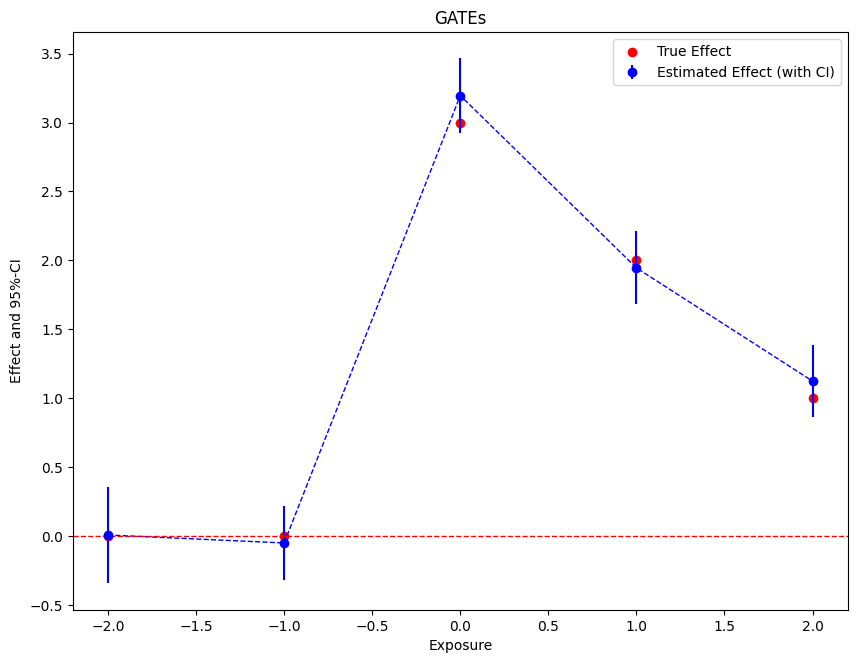

In [91]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()

errors = np.full((2, 2*n_time_periods - 1), np.nan)
errors[0, :] = df["effect"] -   df["lower"]
errors[1, :] = df["upper"] - df["effect"]

plt.errorbar(time_periods[1:], df["effect"], fmt='o', yerr=errors, color='blue',
             ecolor='blue', label='Estimated Effect (with CI)')
ax.plot(time_periods[1:], df["effect"], linestyle='--', color='blue', linewidth=1)

# add horizontal line
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

# add true effect
ax.scatter(x=time_periods[1:], y=[0, 0, 3, 2, 1], c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Exposure')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')